In [4]:
# Step 0: Imports and Global Settings

import os
import sys
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime

warnings.filterwarnings("ignore")

pd.set_option("display.max_columns", 200)
pd.set_option("display.max_rows", 200)
pd.set_option("display.float_format", lambda x: f"{x:,.4f}")

print("Python executable:", sys.executable)


Python executable: /Users/waelsultan/Desktop/USD MS AAI/AAI-530/Final Project/Smart Meter/TeamProject-530/.venv/bin/python


In [5]:
# Step 0B: Define Data Paths

PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), ".."))

DATA_DIR = os.path.join(PROJECT_ROOT, "data")

DAILY_DATASET_PATH = os.path.join(DATA_DIR, "daily_dataset.csv")
HOUSEHOLDS_PATH = os.path.join(DATA_DIR, "informations_households.csv")
ACORN_PATH = os.path.join(DATA_DIR, "acorn_details.csv")
WEATHER_DAILY_PATH = os.path.join(DATA_DIR, "weather_daily_darksky.csv")
WEATHER_HOURLY_PATH = os.path.join(DATA_DIR, "weather_hourly_darksky.csv")
HOLIDAYS_PATH = os.path.join(DATA_DIR, "uk_bank_holidays.csv")

print("DATA_DIR:", DATA_DIR)


DATA_DIR: /Users/waelsultan/Desktop/USD MS AAI/AAI-530/Final Project/Smart Meter/TeamProject-530/data


In [8]:
households = pd.read_csv("../data/informations_households.csv")
daily = pd.read_csv("../data/daily_dataset.csv")
weather_daily = pd.read_csv("../data/weather_daily_darksky.csv")

print("Households:", households.shape)
print("Daily:", daily.shape)
print("Weather:", weather_daily.shape)


Households: (5566, 5)
Daily: (3510433, 9)
Weather: (882, 32)


In [9]:
print("HouseHOLDS COLUMNS")
display(households.head())
print(households.info())

print("\nDAILY DATASET COLUMNS")
display(daily.head())
print(daily.info())

print("\nWEATHER DATASET COLUMNS")
display(weather_daily.head())
print(weather_daily.info())


HouseHOLDS COLUMNS


,LCLid,stdorToU,Acorn,Acorn_grouped,file
0,MAC005492,ToU,ACORN-,ACORN-,block_0
1,MAC001074,ToU,ACORN-,ACORN-,block_0
2,MAC000002,Std,ACORN-A,Affluent,block_0
3,MAC003613,Std,ACORN-A,Affluent,block_0
4,MAC003597,Std,ACORN-A,Affluent,block_0


<class 'pandas.DataFrame'>
RangeIndex: 5566 entries, 0 to 5565
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   LCLid          5566 non-null   str  
 1   stdorToU       5566 non-null   str  
 2   Acorn          5566 non-null   str  
 3   Acorn_grouped  5566 non-null   str  
 4   file           5566 non-null   str  
dtypes: str(5)
memory usage: 217.6 KB
None

DAILY DATASET COLUMNS


,LCLid,day,energy_median,energy_mean,energy_max,energy_count,energy_std,energy_sum,energy_min
0,MAC000131,2011-12-15,0.4850,0.4320,0.8680,22,0.2391,9.5050,0.0720
1,MAC000131,2011-12-16,0.1415,0.2962,1.1160,48,0.2815,14.2160,0.0310
2,MAC000131,2011-12-17,0.1015,0.1898,0.6850,48,0.1884,9.1110,0.0640
3,MAC000131,2011-12-18,0.1140,0.2190,0.6760,48,0.2029,10.5110,0.0650
4,MAC000131,2011-12-19,0.1910,0.3260,0.7880,48,0.2592,15.6470,0.0660


<class 'pandas.DataFrame'>
RangeIndex: 3510433 entries, 0 to 3510432
Data columns (total 9 columns):
 #   Column         Dtype  
---  ------         -----  
 0   LCLid          str    
 1   day            str    
 2   energy_median  float64
 3   energy_mean    float64
 4   energy_max     float64
 5   energy_count   int64  
 6   energy_std     float64
 7   energy_sum     float64
 8   energy_min     float64
dtypes: float64(6), int64(1), str(2)
memory usage: 241.0 MB
None

WEATHER DATASET COLUMNS


,temperatureMax,temperatureMaxTime,windBearing,icon,dewPoint,temperatureMinTime,cloudCover,windSpeed,pressure,apparentTemperatureMinTime,apparentTemperatureHigh,precipType,visibility,humidity,apparentTemperatureHighTime,apparentTemperatureLow,apparentTemperatureMax,uvIndex,time,sunsetTime,temperatureLow,temperatureMin,temperatureHigh,sunriseTime,temperatureHighTime,uvIndexTime,summary,temperatureLowTime,apparentTemperatureMin,apparentTemperatureMaxTime,apparentTemperatureLowTime,moonPhase
0,11.9600,2011-11-11 23:00:00,123,fog,9.4000,2011-11-11 07:00:00,0.7900,3.8800,"1,016.0800",2011-11-11 07:00:00,10.8700,rain,3.3000,0.9500,2011-11-11 19:00:00,10.8700,11.9600,1.0000,2011-11-11 00:00:00,2011-11-11 16:19:21,10.8700,8.8500,10.8700,2011-11-11 07:12:14,2011-11-11 19:00:00,2011-11-11 11:00:00,Foggy until afternoon.,2011-11-11 19:00:00,6.4800,2011-11-11 23:00:00,2011-11-11 19:00:00,0.5200
1,8.5900,2011-12-11 14:00:00,198,partly-cloudy-day,4.4900,2011-12-11 01:00:00,0.5600,3.9400,"1,007.7100",2011-12-11 02:00:00,5.6200,rain,12.0900,0.8800,2011-12-11 19:00:00,-0.6400,5.7200,1.0000,2011-12-11 00:00:00,2011-12-11 15:52:53,3.0900,2.4800,8.5900,2011-12-11 07:57:02,2011-12-11 14:00:00,2011-12-11 12:00:00,Partly cloudy throughout the day.,2011-12-12 07:00:00,0.1100,2011-12-11 20:00:00,2011-12-12 08:00:00,0.5300
2,10.3300,2011-12-27 02:00:00,225,partly-cloudy-day,5.4700,2011-12-27 23:00:00,0.8500,3.5400,"1,032.7600",2011-12-27 22:00:00,10.3300,rain,13.3900,0.7400,2011-12-27 14:00:00,5.5200,10.3300,0.0000,2011-12-27 00:00:00,2011-12-27 15:57:56,8.0300,8.0300,10.3300,2011-12-27 08:07:06,2011-12-27 14:00:00,2011-12-27 00:00:00,Mostly cloudy throughout the day.,2011-12-27 23:00:00,5.5900,2011-12-27 02:00:00,2011-12-28 00:00:00,0.1000
3,8.0700,2011-12-02 23:00:00,232,wind,3.6900,2011-12-02 07:00:00,0.3200,3.0000,"1,012.1200",2011-12-02 07:00:00,5.3300,rain,11.8900,0.8700,2011-12-02 12:00:00,3.2600,5.3300,1.0000,2011-12-02 00:00:00,2011-12-02 15:56:17,6.3300,2.5600,7.3600,2011-12-02 07:46:09,2011-12-02 12:00:00,2011-12-02 10:00:00,Partly cloudy throughout the day and breezy ov...,2011-12-02 19:00:00,0.4600,2011-12-02 12:00:00,2011-12-02 19:00:00,0.2500
4,8.2200,2011-12-24 23:00:00,252,partly-cloudy-night,2.7900,2011-12-24 07:00:00,0.3700,4.4600,"1,028.1700",2011-12-24 07:00:00,5.0200,rain,13.1600,0.8000,2011-12-24 15:00:00,4.3700,5.3200,1.0000,2011-12-24 00:00:00,2011-12-24 15:55:55,7.4500,3.1700,7.9300,2011-12-24 08:06:15,2011-12-24 15:00:00,2011-12-24 13:00:00,Mostly cloudy throughout the day.,2011-12-24 19:00:00,-0.5100,2011-12-24 23:00:00,2011-12-24 20:00:00,0.9900


<class 'pandas.DataFrame'>
RangeIndex: 882 entries, 0 to 881
Data columns (total 32 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   temperatureMax               882 non-null    float64
 1   temperatureMaxTime           882 non-null    str    
 2   windBearing                  882 non-null    int64  
 3   icon                         882 non-null    str    
 4   dewPoint                     882 non-null    float64
 5   temperatureMinTime           882 non-null    str    
 6   cloudCover                   881 non-null    float64
 7   windSpeed                    882 non-null    float64
 8   pressure                     882 non-null    float64
 9   apparentTemperatureMinTime   882 non-null    str    
 10  apparentTemperatureHigh      882 non-null    float64
 11  precipType                   882 non-null    str    
 12  visibility                   882 non-null    float64
 13  humidity                     88

In [11]:
# Convert date columns to datetime
daily["day"] = pd.to_datetime(daily["day"])
weather_daily["temperatureMaxTime"] = pd.to_datetime(weather_daily["temperatureMaxTime"])
weather_daily["temperatureMinTime"] = pd.to_datetime(weather_daily["temperatureMinTime"])

# Create a clean date column in weather to match daily
weather_daily["day"] = weather_daily["temperatureMaxTime"].dt.date
daily["day"] = daily["day"].dt.date

print(daily["day"].min(), daily["day"].max())
print(weather_daily["day"].min(), weather_daily["day"].max())


2011-11-23 2014-02-28
2011-11-01 2014-03-31


In [12]:
daily_weather = daily.merge(
    weather_daily,
    on="day",
    how="left"
)

daily_weather.shape


(3562661, 41)

In [13]:
full_df = daily_weather.merge(
    households,
    on="LCLid",
    how="left"
)

full_df.shape


(3562661, 45)

In [14]:
full_df.isna().mean().sort_values(ascending=False).head(15)


uvIndex                  0.0161
cloudCover               0.0161
uvIndexTime              0.0161
humidity                 0.0147
temperatureMin           0.0147
apparentTemperatureLow   0.0147
apparentTemperatureMax   0.0147
time                     0.0147
sunsetTime               0.0147
temperatureLow           0.0147
temperatureHigh          0.0147
visibility               0.0147
sunriseTime              0.0147
temperatureHighTime      0.0147
summary                  0.0147
dtype: float64

In [15]:
full_df[[
    "energy_mean",
    "energy_sum",
    "energy_max",
    "temperatureMax",
    "temperatureMin",
    "windSpeed",
    "humidity"
]].describe()


,energy_mean,energy_sum,energy_max,temperatureMax,temperatureMin,windSpeed,humidity
count,"3,562,631.0000","3,562,631.0000","3,562,631.0000","3,510,247.0000","3,510,247.0000","3,510,247.0000","3,510,247.0000"
mean,0.2114,10.1097,0.8337,14.1338,7.8687,3.5901,0.7796
std,0.1904,9.1062,0.6675,6.5381,5.0857,1.6937,0.0971
min,0.0000,0.0000,0.0000,-0.0600,-5.6400,0.2000,0.4300
25%,0.0980,4.6790,0.3450,9.4200,3.6800,2.3800,0.7100
50%,0.1632,7.8080,0.6880,13.2700,7.6000,3.4500,0.7900
75%,0.2621,12.5530,1.1270,18.8200,12.0700,4.5700,0.8600
max,6.9283,332.5560,10.7610,32.4000,20.5400,9.9600,0.9800


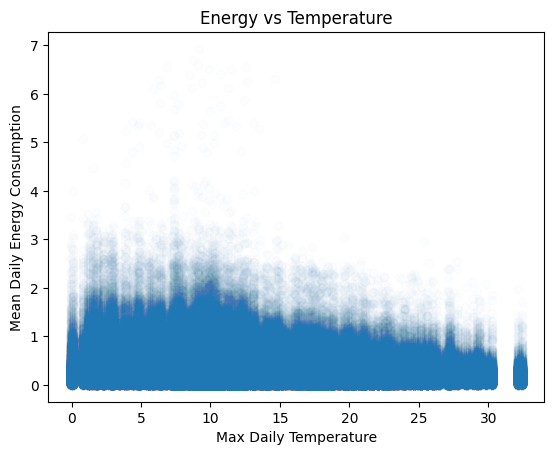

In [16]:
import matplotlib.pyplot as plt

plt.figure()
plt.scatter(full_df["temperatureMax"], full_df["energy_mean"], alpha=0.01)
plt.xlabel("Max Daily Temperature")
plt.ylabel("Mean Daily Energy Consumption")
plt.title("Energy vs Temperature")
plt.show()


In [17]:
acorn_energy = (
    full_df
    .groupby("Acorn_grouped")["energy_mean"]
    .mean()
    .sort_values(ascending=False)
)

acorn_energy


Acorn_grouped
ACORN-        0.2511
ACORN-U       0.2427
Affluent      0.2396
Comfortable   0.2089
Adversity     0.1777
Name: energy_mean, dtype: float64

Descriptive Statistics for Energy and Weather
Summary Statistics

We computed descriptive statistics for key energy and weather variables across the merged dataset.

Key observations:

Average daily energy_mean is approximately 0.21, with a right-skewed distribution as indicated by a max of 6.93.

energy_sum shows substantial variability, with a mean of 10.11 and a max of 332.56, suggesting some extreme high-usage days.

Temperature ranges are realistic for London:

Mean max temperature ≈ 14.1°C

Mean min temperature ≈ 7.9°C

Humidity is consistently high with a mean of 0.78, which is typical for the London climate.

These statistics confirm that the merged dataset is clean and within expected physical ranges.

Relationship Between Energy Consumption and Temperature
Energy vs Temperature Scatter Plot

The scatter plot of mean daily energy consumption vs maximum daily temperature shows a clear pattern:

Higher energy usage tends to occur at lower temperatures.

As temperature increases, average daily energy consumption generally decreases.

This suggests heating demand is a major driver of electricity usage in this dataset.

This inverse relationship is consistent with expectations in a cooler climate, where colder days increase heating-related electricity demand.

Energy Consumption by Socio-Economic Group (ACORN)
Mean Energy by ACORN Group

Average daily energy consumption by ACORN group:

ACORN-: 0.2511

ACORN-U: 0.2427

Affluent: 0.2396

Comfortable: 0.2089

Adversity: 0.1777

Key insights:

Higher-income and less classified groups (ACORN-, ACORN-U, Affluent) tend to have higher average energy usage.

The Adversity group shows the lowest mean energy consumption.

This suggests a socio-economic effect on electricity usage, potentially driven by home size, appliance ownership, and heating behavior.

In [23]:
daily["day"] = pd.to_datetime(daily["day"])




In [24]:
merged = daily.merge(households, on="LCLid", how="left")
merged = merged.merge(weather, left_on="day", right_on="time", how="left")

merged.shape


(3510433, 45)

In [25]:
merged[["energy_mean", "temperatureMax", "humidity"]].isna().mean()


energy_mean      0.0000
temperatureMax   0.5593
humidity         0.5593
dtype: float64

In [26]:
merged[["energy_mean", "temperatureMax", "humidity"]].describe()


,energy_mean,temperatureMax,humidity
count,"3,510,403.0000","1,546,951.0000","1,546,951.0000"
mean,0.2117,8.6154,0.8221
std,0.1908,3.3664,0.0738
min,0.0000,-0.0600,0.5900
25%,0.0981,6.6200,0.7800
50%,0.1633,9.2100,0.8300
75%,0.2625,10.8200,0.8800
max,6.9283,19.4800,0.9700


In [27]:
eda_weather = merged.dropna(subset=["temperatureMax", "humidity"])
eda_weather.shape


(1546951, 45)

In [28]:
eda_weather[["energy_mean", "temperatureMax", "humidity"]].corr()


,energy_mean,temperatureMax,humidity
energy_mean,1.0000,-0.0599,0.0002
temperatureMax,-0.0599,1.0000,0.1475
humidity,0.0002,0.1475,1.0000


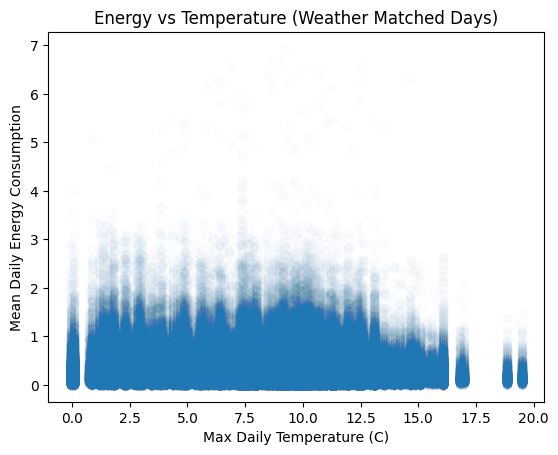

In [29]:
plt.figure()
plt.scatter(
    eda_weather["temperatureMax"],
    eda_weather["energy_mean"],
    alpha=0.01
)
plt.xlabel("Max Daily Temperature (C)")
plt.ylabel("Mean Daily Energy Consumption")
plt.title("Energy vs Temperature (Weather Matched Days)")
plt.show()


<Figure size 800x500 with 0 Axes>

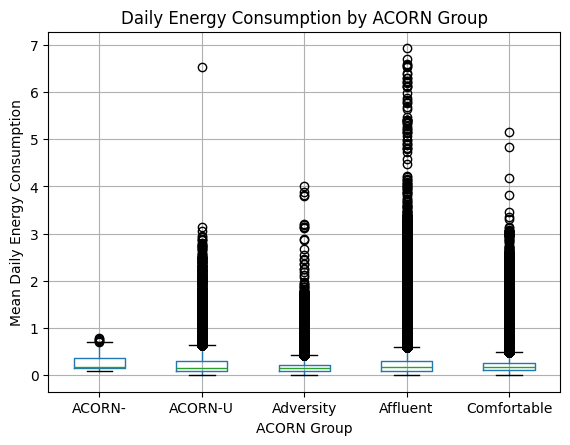

In [33]:
plt.figure(figsize=(8,5))
merged.boxplot(column="energy_mean", by="Acorn_grouped")
plt.title("Daily Energy Consumption by ACORN Group")
plt.suptitle("")
plt.xlabel("ACORN Group")
plt.ylabel("Mean Daily Energy Consumption")
plt.show()


In [34]:
acorn_summary = (
    merged
    .groupby("Acorn_grouped")["energy_mean"]
    .agg(["count", "mean", "median", "std"])
    .sort_values("mean", ascending=False)
)

acorn_summary


,count,mean,median,std
Acorn_grouped,,,,
ACORN-,781,0.2512,0.1716,0.1600
ACORN-U,29552,0.2432,0.1535,0.2773
Affluent,1407678,0.2400,0.1720,0.2355
Comfortable,937061,0.2092,0.1736,0.1641
Adversity,1135331,0.1779,0.1470,0.1320


In [38]:
### 1. Time-Based Patterns (Seasonality + Weekly Rhythm)
### 1A. Add Month and Day of Week

# Make sure day is datetime
merged["day"] = pd.to_datetime(merged["day"])

# Add time features
merged["month"] = merged["day"].dt.month
merged["month_name"] = merged["day"].dt.month_name()
merged["weekday"] = merged["day"].dt.day_name()
merged["weekday_num"] = merged["day"].dt.weekday


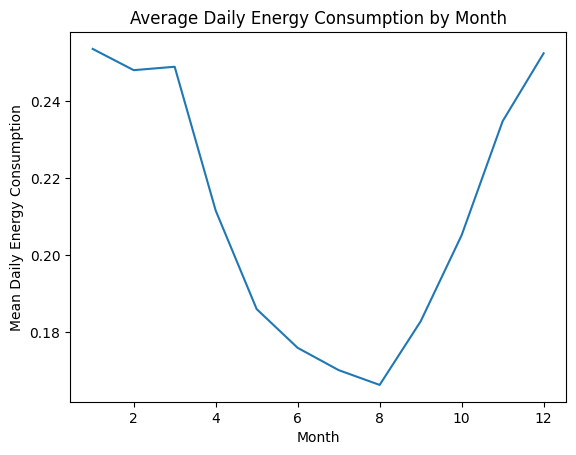

,month,energy_mean
0,1,0.2536
1,2,0.2481
2,3,0.2490
3,4,0.2116
4,5,0.1860
5,6,0.1759
6,7,0.1701
7,8,0.1663
8,9,0.1828
9,10,0.2052


In [39]:
# 1B. Average Energy by Month
monthly_avg = (
    merged.groupby("month")["energy_mean"]
    .mean()
    .reset_index()
)

plt.figure()
plt.plot(monthly_avg["month"], monthly_avg["energy_mean"])
plt.title("Average Daily Energy Consumption by Month")
plt.xlabel("Month")
plt.ylabel("Mean Daily Energy Consumption")
plt.show()

monthly_avg



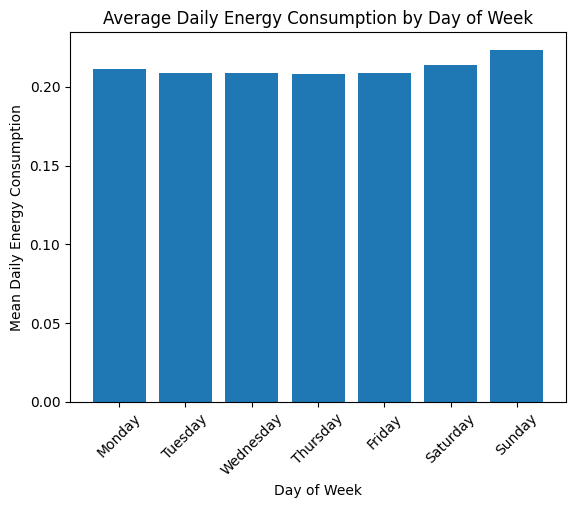

,weekday_num,weekday,energy_mean
0,0,Monday,0.2114
1,1,Tuesday,0.2087
2,2,Wednesday,0.2085
3,3,Thursday,0.2079
4,4,Friday,0.2086
5,5,Saturday,0.2136
6,6,Sunday,0.2234


In [42]:
# 1C Average Energy by Day of Week

weekday_avg = (
    merged.groupby(["weekday_num", "weekday"])["energy_mean"]
    .mean()
    .reset_index()
    .sort_values("weekday_num")
)

plt.figure()
plt.bar(weekday_avg["weekday"], weekday_avg["energy_mean"])
plt.title("Average Daily Energy Consumption by Day of Week")
plt.xlabel("Day of Week")
plt.ylabel("Mean Daily Energy Consumption")
plt.xticks(rotation=45)
plt.show()

weekday_avg


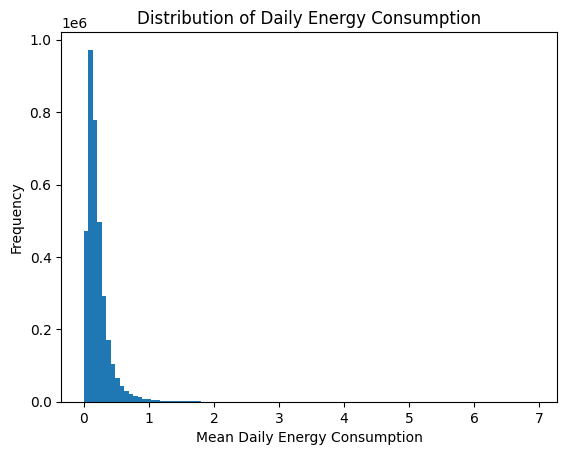

In [43]:
#2. Distribution of Energy Consumption
#2A. Raw Distribution

plt.figure()
plt.hist(merged["energy_mean"], bins=100)
plt.title("Distribution of Daily Energy Consumption")
plt.xlabel("Mean Daily Energy Consumption")
plt.ylabel("Frequency")
plt.show()


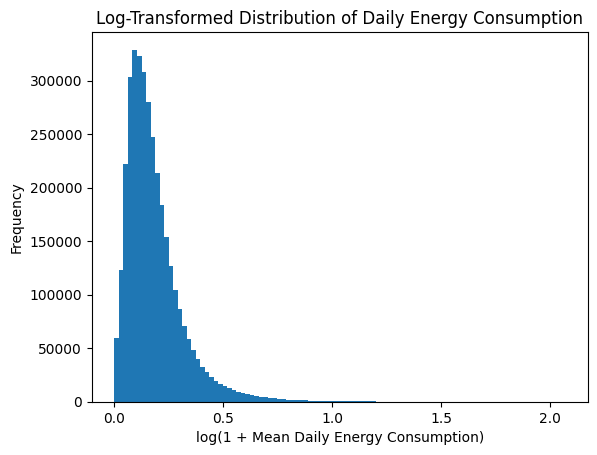

In [44]:
merged["log_energy_mean"] = np.log1p(merged["energy_mean"])

plt.figure()
plt.hist(merged["log_energy_mean"], bins=100)
plt.title("Log-Transformed Distribution of Daily Energy Consumption")
plt.xlabel("log(1 + Mean Daily Energy Consumption)")
plt.ylabel("Frequency")
plt.show()


In [45]:
#3. Household-Level Aggregation
#3A. Average Daily Energy Per Household

household_avg = (
    merged.groupby("LCLid")
    .agg(
        avg_daily_energy=("energy_mean", "mean"),
        acorn_group=("Acorn_grouped", "first")
    )
    .reset_index()
)

household_avg.describe()


,avg_daily_energy
count,"5,561.0000"
mean,0.2129
std,0.1562
min,0.0000
25%,0.1123
50%,0.1735
75%,0.2680
max,2.1114


<Figure size 640x480 with 0 Axes>

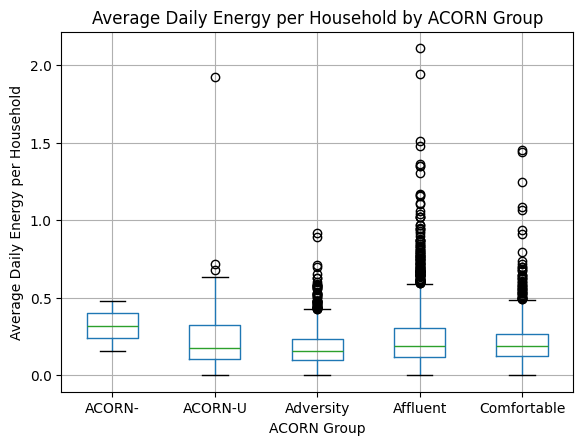

,count,mean,std,min,25%,50%,75%,max
acorn_group,,,,,,,,
ACORN-,2.0000,0.3194,0.2303,0.1565,0.2379,0.3194,0.4008,0.4822
ACORN-U,49.0000,0.2701,0.3056,0.0000,0.1026,0.1796,0.3255,1.9277
Adversity,"1,813.0000",0.1785,0.1070,0.0000,0.1015,0.1572,0.2323,0.9157
Affluent,"2,192.0000",0.2410,0.1906,0.0017,0.1172,0.1874,0.3071,2.1114
Comfortable,"1,505.0000",0.2112,0.1334,0.0004,0.1221,0.1866,0.2678,1.4543


In [46]:
#3B. Household Energy by ACORN Group
plt.figure()
household_avg.boxplot(column="avg_daily_energy", by="acorn_group")
plt.title("Average Daily Energy per Household by ACORN Group")
plt.suptitle("")
plt.xlabel("ACORN Group")
plt.ylabel("Average Daily Energy per Household")
plt.show()

household_avg.groupby("acorn_group")["avg_daily_energy"].describe()
